# Решение задачи регрессии с помощью нейронных сетей.
# Предсказание стоимости ноутбуков по их характеристикам.


#  Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder # Метод кодирования категориальных переменных

from tensorflow.keras.models import Sequential # Модель последовательной НС
from tensorflow.keras.layers import Dropout, Normalization # Dropout против переобучения, нормализация данных
from tensorflow.keras.optimizers import Adam # Оптимизатор
from tensorflow.keras import layers, regularizers # Настройка архитектуры НС, регуляризация против переобчуния

#  Предобработка данных

## Смотрим содержание датасета

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/laptop_price.csv', encoding='latin-1')
data.head(10)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
5,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
6,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
7,8,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,256GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1158.70
8,9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
9,10,Acer,Swift 3,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6kg,770.00


Можно видеть, что в датасете довольно много столбцов с категориальными данными, требующими предварительной обработки и перевода в численные.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


Датасет состоит из 13 столбцов (один из них хранит в себе тип int, два - тип float, остальные десять - тип object) и 1303 строк. В столбцах отсутствуют пропущенные значения (тип NULL).

Посмотрим на уникальные значения в различных столбцах с категориальными данными, требующих обработки:

In [ ]:
data['Company'].value_counts()

Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64

In [ ]:
data['Product'].value_counts()

Product
XPS 13                                     30
Inspiron 3567                              29
250 G6                                     21
Legion Y520-15IKBN                         19
Vostro 3568                                19
                                           ..
15-bw007nv (A10-9620P/6GB/128GB/Radeon      1
SmartBook 130                               1
A541NA-GO342 (N3350/4GB/500GB/Linux)        1
17-X047na (i3-6006U/8GB/1TB/W10)            1
V330-15IKB (i5-8250U/4GB/500GB/FHD/W10)     1
Name: count, Length: 618, dtype: int64

Столбец Product содержит слишком много уникальных значений (618) относительно количесвта строк в датасете (1303), поэтому в дальнейшем удалим его.

In [ ]:
data['TypeName'].value_counts()

TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: count, dtype: int64

In [ ]:
data['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x14

In [ ]:
data['Cpu'].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz       190
Intel Core i7 7700HQ 2.8GHz      146
Intel Core i7 7500U 2.7GHz       134
Intel Core i7 8550U 1.8GHz        73
Intel Core i5 8250U 1.6GHz        72
                                ... 
Intel Core M M3-6Y30 0.9GHz        1
AMD A9-Series 9420 2.9GHz          1
Intel Core i3 6006U 2.2GHz         1
AMD A6-Series 7310 2GHz            1
Intel Xeon E3-1535M v6 3.1GHz      1
Name: count, Length: 118, dtype: int64

In [ ]:
data['Memory'].value_counts()

Memory
256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD         

In [ ]:
data['Gpu'].value_counts()

Gpu
Intel HD Graphics 620      281
Intel HD Graphics 520      185
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
AMD Radeon 540               1
ARM Mali T860 MP4            1
Name: count, Length: 110, dtype: int64

In [ ]:
data['OpSys'].value_counts()

OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64

Посмотрим на распределение цены в датасете:

In [ ]:
data['Price_euros'].describe()

count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64

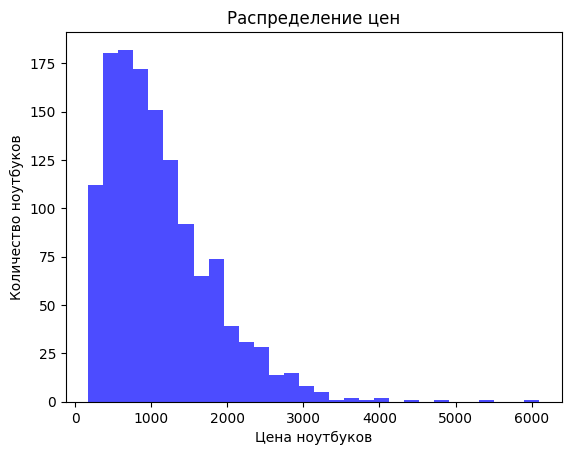

In [ ]:
plt.hist(data['Price_euros'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Цена ноутбуков')
plt.ylabel('Количество ноутбуков')
plt.title('Распределение цен')
plt.show()

## Непосредственная обработка данных

Для обработки данных были приняты следующие решения:

*   Разбить столбец ScreenResolution на столбцы IPS (0/1), Touchscreen (0/1), res_X и res_Y (разрешение экрана по горизонтали и вертикали)
* Разбить столбец Cpu на столбцы Cpu_name и Cpu_freq (частота)
*В столбце Memory перевести всё в GB и разбить на четыре столбца SSD, HDD, Hybrid, Flash Storage
*Убрать GB и kg в столбцах Ram и Weight

In [ ]:
# Обработка столбца ScreenResolution
data['Ips']=data['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0) # Есть IPS? 0/1
data['Touchscreen']=data['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0) ## Есть Touchscreen? 0/1
var=data['ScreenResolution'].str.split('x',n=1,expand=True) # Разбиение разрешения экрана на горизонтальную и вертикальную составляющие
data['res_X']=var[0]
data['res_Y']=var[1]
data['res_X']=data['res_Y'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x:x[0])
data[['res_Y','res_X']]=data[['res_Y','res_X']].astype(int)
data.drop('ScreenResolution', axis=1, inplace=True) # Удаляем первоначальный столбец

# Обработка столбца Cpu
data['Cpu_name']=data['Cpu'].apply(lambda x:" ".join(x.split()[0:3])) # Название процессора
data['Cpu_freq']=data['Cpu'].apply(lambda x:" ".join(x.split()[-1:])) # Частота процессора
data['Cpu_freq']=data['Cpu_freq'].str.replace('GHz', '').astype(float) # Убираем размерность GHz
data.drop('Cpu', axis=1, inplace=True) # Удаляем первоначальный столбец

# Перевод столбца Memory в GB
data['Memory'] = data['Memory'].str.replace('TB', '000GB')

# Замена записи по типу 256GB SSD + 256GB SSD на 512GB SSD (суммирование памяти одинакого типа)
data['Memory'] = data['Memory'].str.replace('256GB SSD +  256GB SSD', '512GB SSD')
data['Memory'] = data['Memory'].str.replace('512GB SSD +  256GB SSD', '768GB SSD')
data['Memory'] = data['Memory'].str.replace('512GB SSD +  512GB SSD', '1024GB SSD')
data['Memory'] = data['Memory'].str.replace('1000GB HDD +  1000GB HDD', '2000GB HDD')

# Создание столбцов для каждого типа памяти
data['SSD'] = data['Memory'].str.extract('(\d+)GB SSD').fillna(0).astype(int) # Столбец SSD
data['HDD'] = data['Memory'].str.extract('(\d+)GB HDD').fillna(0).astype(int) # Столбец HDD
data['Flash Storage'] = data['Memory'].str.extract('(\d+)GB Flash Storage').fillna(0).astype(int) # Столбец Flash Storage
data['Hybrid'] = data['Memory'].str.extract('(\d+)GB Hybrid').fillna(0).astype(int) # Столбец Hybrid
data.drop('Memory', axis=1, inplace=True) # Удаляем первоначальный столбец

data['Ram']=data['Ram'].apply(lambda x:int(x[0])) # Убираем размерность GB в столбце Ram
data['Weight'] = data['Weight'].astype(str).str.replace('kg', '').astype(float) # Убираем размерность kg в столбце Weight

# Удаляем первоначальные столбцы
data.drop('Gpu', axis=1, inplace=True)
data.drop('laptop_ID', axis=1, inplace=True)
data.drop('Product', axis=1, inplace=True)

In [ ]:
data

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Ips,Touchscreen,res_X,res_Y,Cpu_name,Cpu_freq,SSD,HDD,Flash Storage,Hybrid
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,1,0,1600,1600,Intel Core i5,2.3,128,0,0,0
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,0,0,900,900,Intel Core i5,1.8,0,0,128,0
2,HP,Notebook,15.6,8,No OS,1.86,575.00,0,0,1080,1080,Intel Core i5,2.5,256,0,0,0
3,Apple,Ultrabook,15.4,1,macOS,1.83,2537.45,1,0,1800,1800,Intel Core i7,2.7,512,0,0,0
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,1,0,1600,1600,Intel Core i5,3.1,256,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,1,1,1080,1080,Intel Core i7,2.5,128,0,0,0
1299,Lenovo,2 in 1 Convertible,13.3,1,Windows 10,1.30,1499.00,1,1,1800,1800,Intel Core i7,2.5,512,0,0,0
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,0,0,768,768,Intel Celeron Dual,1.6,0,0,64,0
1301,HP,Notebook,15.6,6,Windows 10,2.19,764.00,0,0,768,768,Intel Core i7,2.5,0,1000,0,0


Для преобразования категориалных данных в численный вид был выбран тип кодирования one-hot encoding из библиотеки sklearn (создаёт столбцы для всех уникальных категорий и расставляются 1 и 0 соответственно).

In [ ]:
#Получаем все категориальные столбцы
cat_columns = data.select_dtypes(['object']).columns

encoder = OneHotEncoder(handle_unknown='ignore')

#Переводим категориальные столбцы в числовые (бинарные)
encoder_data = pd.DataFrame(encoder.fit_transform(data[cat_columns]).toarray())

#Присоединяем преобразованные столбцы к датасету
data = data.join(encoder_data)

# Удаляем изначальные категориальные столбцы
data.drop(cat_columns, axis= 1 , inplace= True )

In [ ]:
data

,Inches,Ram,Weight,Price_euros,Ips,Touchscreen,res_X,res_Y,Cpu_freq,SSD,...,64,65,66,67,68,69,70,71,72,73
0,13.3,8,1.37,1339.69,1,0,1600,1600,2.3,128,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.3,8,1.34,898.94,0,0,900,900,1.8,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.6,8,1.86,575.00,0,0,1080,1080,2.5,256,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.4,1,1.83,2537.45,1,0,1800,1800,2.7,512,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,13.3,8,1.37,1803.60,1,0,1600,1600,3.1,256,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,14.0,4,1.80,638.00,1,1,1080,1080,2.5,128,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1299,13.3,1,1.30,1499.00,1,1,1800,1800,2.5,512,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1300,14.0,2,1.50,229.00,0,0,768,768,1.6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1301,15.6,6,2.19,764.00,0,0,768,768,2.5,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.describe()

,Inches,Ram,Weight,Price_euros,Ips,Touchscreen,res_X,res_Y,Cpu_freq,SSD,...,64,65,66,67,68,69,70,71,72,73
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,...,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,5.395242,2.038734,1123.686992,0.280123,0.147352,1070.830391,1070.830391,2.298772,183.732924,...,0.006140,0.014582,0.104375,0.324635,0.404451,0.002302,0.020721,0.001535,0.001535,0.000767
std,1.426304,2.726308,0.665475,699.009043,0.449231,0.354593,284.519410,284.519410,0.506340,186.966903,...,0.078145,0.119917,0.305863,0.468418,0.490974,0.047946,0.142505,0.039163,0.039163,0.027703
min,10.100000,1.000000,0.690000,174.000000,0.000000,0.000000,768.000000,768.000000,0.900000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,599.000000,0.000000,0.000000,900.000000,900.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,6.000000,2.040000,977.000000,0.000000,0.000000,1080.000000,1080.000000,2.500000,256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.600000,8.000000,2.300000,1487.880000,1.000000,0.000000,1080.000000,1080.000000,2.700000,256.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.400000,8.000000,4.700000,6099.000000,1.000000,1.000000,2160.000000,2160.000000,3.600000,1024.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Нейронная сеть

## Создание тренировочной и тестовой выборки

In [ ]:
train_dataset = data.sample(frac=0.85, random_state=0) # 85% - тренировочная выборка
test_dataset = data.drop(train_dataset.index) # остальные 15% - тестовая выборка

X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('Price_euros')
y_test = X_test.pop('Price_euros')

## Архитектура нейросети

In [ ]:
normalizer = Normalization(axis=-1) # Слой нормализации входных данный
normalizer.adapt(np.array(X_train))

model = Sequential([
      normalizer,
      layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dropout(0.5),
      layers.Dense(1200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dropout(0.5),
      layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dense(1, activation='linear')
      ])

model.compile(loss='mse',
                optimizer = Adam(0.001),
                metrics=['mae'])

## Обучение нейросети

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  (None, 86)                173       
 tion)                                                           
                                                                 
 dense_28 (Dense)            (None, 300)               26100     
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_29 (Dense)            (None, 1200)              361200    
                                                                 
 dropout_5 (Dropout)         (None, 1200)              0         
                                                                 
 dense_30 (Dense)            (None, 200)               240200    
                                                      

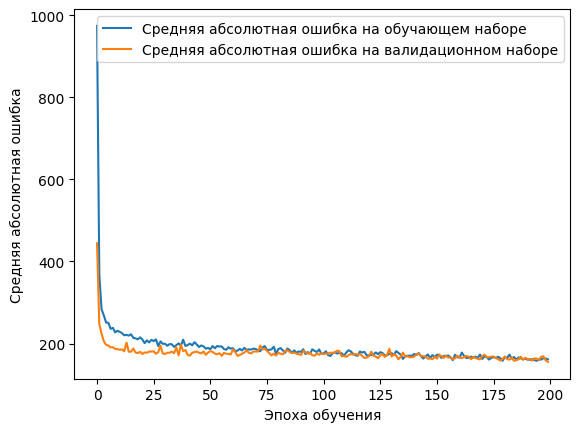

In [ ]:
model.summary()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    verbose=1, epochs=200)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

[66475.59375, 175.42770385742188]

## Результат на тестовой выборке

In [ ]:
y_predict = model.predict(X_test).flatten()
abs(y_test - y_predict).describe()

7/7 [==============================] - 0s 6ms/step


count     195.000000
mean      175.427673
std       189.431634
min         2.398926
25%        52.451007
50%       118.394104
75%       248.495636
max      1590.588379
Name: Price_euros, dtype: float64

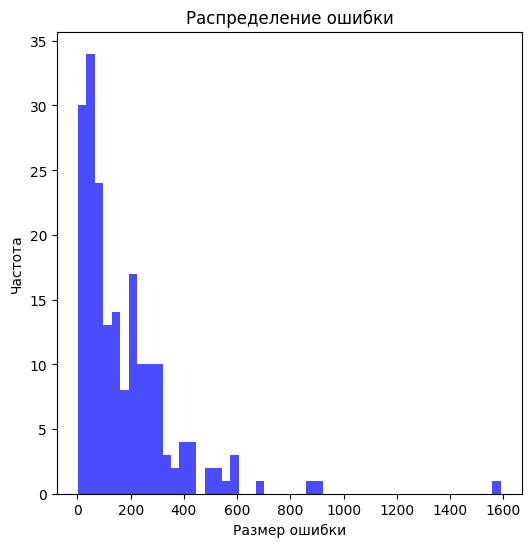

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(abs(y_test - y_predict), bins=50, color='blue', alpha=0.7)
plt.xlabel('Размер ошибки')
plt.ylabel('Частота')
plt.title('Распределение ошибки')
plt.show()

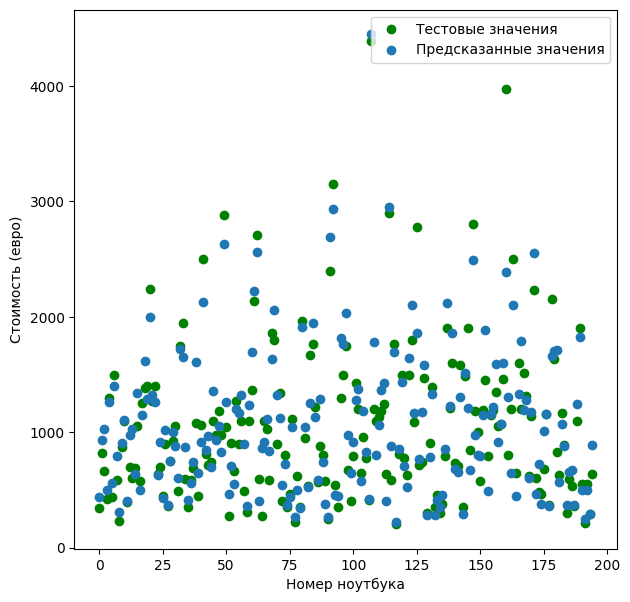

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(range(0, len(y_test)), y_test, color="green", label="Тестовые значения")
plt.scatter(range(0, len(y_test)), y_predict, label="Предсказанные значения")
plt.xlabel("Номер ноутбука")
plt.ylabel("Стоимость (евро)")
plt.legend()
plt.show()